In [1]:
import nest
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import time
nest.ResetKernel()
resolution = 0.1
nest.SetKernelStatus({
    "resolution": resolution,   
    "print_time": True
})
np.random.seed(42)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Jul 24 2025 05:27:26

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Jan 24 13:08:59 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


# Input Architecture 

In [2]:
# ==================== PARÁMETROS DEL MODELO ====================
# Neuron model parameters (iaf_cond_alpha como en el artículo)
neuron_params = {
    "C_m": 200.0,        # pF (equivale a tau=20 ms con gL=10 nS)
    "g_L": 10.0,         # nS
    "E_L": -60.0,        # mV
    "V_th": -50.0,       # mV
    "V_reset": -60.0,    # mV
    "t_ref": 5.0,        # ms
    "E_ex": 0.0,         # mV
    "E_in": -80.0        # mV
}

# Synapse time constants (EXACTAMENTE como en el artículo)
tau_ex = 5.0    # ms (τ_E = 5 ms)
tau_in = 10.0   # ms (τ_I = 10 ms)

# ==================== CREAR NEURONA POSTSINÁPTICA ====================
post = nest.Create("iaf_cond_alpha", params={
    **neuron_params, 
    "tau_syn_ex": tau_ex, 
    "tau_syn_in": tau_in
})

# ==================== CONFIGURACIÓN DE GRUPOS ====================
n_groups = 8                    
N_exc_per_group = 100           
N_inh_per_group = 25           


# ==================== CREAR NEURONAS PARROT POR GRUPO ====================
exc_parrots = []
inh_parrots = []

for g in range(n_groups):
    exc_parrots.append(nest.Create("parrot_neuron", N_exc_per_group))
    inh_parrots.append(nest.Create("parrot_neuron", N_inh_per_group))


# ==================== GENERAR SEÑALES MODULADAS ====================
# Señales de Ornstein-Uhlenbeck con τ = 50 ms (como en el artículo)
T_sim = 10000.0  # ms
dt_signal = 5.0  # ms
tau_signal = 50.0  # ms
times = np.arange(dt_signal, T_sim + dt_signal, dt_signal)
alpha = dt_signal / tau_signal

rate_mean = 10.0  # Hz
rate_std = 5.0    # Hz

signals = []
for g in range(n_groups):
    noise = np.random.randn(len(times))
    signal = np.zeros_like(noise)

    for i in range(1, len(signal)):
        signal[i] = signal[i-1] + alpha * (-signal[i-1] + noise[i])

    signal = (signal - np.mean(signal)) / np.std(signal)
    rates = rate_mean + rate_std * signal
    rates[rates < 0.1] = 0.1
    
    signals.append(rates)

# ==================== SINTONIZACIÓN DE PESOS EXCITATORIOS ====================
# Un grupo preferido (en el artículo es el grupo 5, índice 4)
preferred_group = 4  # Grupo 5 (0-based index 4)
w_exc_max = 3.0   # nS para grupo preferido
w_exc_min = 1.5     # nS para grupos no preferidos


w_exc_by_group = []
for g in range(n_groups):
    if g == preferred_group:
        w_exc_by_group.append(w_exc_max)
    else:
        # Decaimiento exponencial de pesos según distancia al preferido
        distance = abs(g - preferred_group)
        weight = w_exc_min + (w_exc_max - w_exc_min) * np.exp(-distance/2.0)
        w_exc_by_group.append(weight)

# Mostrar pesos
for g, w in enumerate(w_exc_by_group):
    pref = "★" if g == preferred_group else " "
    #print(f"  Grupo {g+1}: {w:.2f} nS {pref}")

# ==================== CREAR GENERADORES DE POISSON ====================
exc_gens = []
inh_gens = []

for g in range(n_groups):
    # Un generador para todas las excitatorias del grupo (misma señal)
    exc_gen = nest.Create("inhomogeneous_poisson_generator", params={
    "rate_times": times.tolist(),
    "rate_values": signals[g].tolist(),
    "origin": 0.0,
    "start": 0.0
     })

    inh_gen = nest.Create("inhomogeneous_poisson_generator", params={
    "rate_times": times.tolist(),
    "rate_values": signals[g].tolist(),
    "origin": 0.0,
    "start": 0.0
    })

    
    exc_gens.append(exc_gen)
    inh_gens.append(inh_gen)

# ==================== PARÁMETROS DE SINAPSIS ====================
delay = 1.0  # ms (mismo para todas)

# Parámetros de plasticidad inhibitoria (Vogels-Sprekeler)
inh_syn_params = {
    "synapse_model": "vogels_sprekeler_synapse",
    "weight": -10,      # Peso inicial DÉBIL (importante)
    "delay": delay,
    "eta": 0.005,        # Tasa de aprendizaje
    "alpha": 0.2,      # Ratio
    "tau": 20.0,        # ms (constante de tiempo STDP)
    "Wmax": -200.0,      # Peso máximo
}

# ==================== CONEXIONES ====================

start_time = time.time()

for g in range(n_groups):
    # 1. Conectar generadores a neuronas parrot (todo a todo dentro del grupo)
    nest.Connect(exc_gens[g], exc_parrots[g], conn_spec="all_to_all")
    nest.Connect(inh_gens[g], inh_parrots[g], conn_spec="all_to_all")
    
    # 2. Conectar excitatorias a post (pesos fijos sintonizados)
    nest.Connect(
    exc_parrots[g], post,
    syn_spec={
        "synapse_model": "static_synapse",
        "weight": w_exc_by_group[g],
        "delay": delay,
        "receptor_type": 0
    })
    
    # 3. Conectar inhibitorias a post (con plasticidad)
    nest.Connect(
    inh_parrots[g], post,
    syn_spec={
        **inh_syn_params,
        "receptor_type": 0
    }
)


inh_conns = nest.GetConnections(
    target=post,
    synapse_model="vogels_sprekeler_synapse"
)


# Fig1 (D) usando iaf_cond_alpha

In [12]:

import nest
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import time
nest.ResetKernel()
resolution = 0.1
nest.SetKernelStatus({
    "resolution": resolution,   
    "print_time": True
})
np.random.seed(42)

# ==================== PARÁMETROS DEL MODELO ====================
# Neuron model parameters (iaf_cond_alpha como en el artículo)
neuron_params = {
    "C_m": 200.0,        # pF (equivale a tau=20 ms con gL=10 nS)
    "g_L": 10.0,         # nS
    "E_L": -60.0,        # mV
    "V_th": -50.0,       # mV
    "V_reset": -60.0,    # mV
    "t_ref": 5.0,        # ms
    "E_ex": 0.0,         # mV
    "E_in": -80.0        # mV
}

# Synapse time constants (EXACTAMENTE como en el artículo)
tau_ex = 5.0    # ms (τ_E = 5 ms)
tau_in = 10.0   # ms (τ_I = 10 ms)

# ==================== CREAR NEURONA POSTSINÁPTICA ====================
post = nest.Create("iaf_cond_alpha", params={
    **neuron_params, 
    "tau_syn_ex": tau_ex, 
    "tau_syn_in": tau_in
})

# ==================== CONFIGURACIÓN DE GRUPOS ====================
n_groups = 8                    
N_exc_per_group = 100           
N_inh_per_group = 25           


# ==================== CREAR NEURONAS PARROT POR GRUPO ====================
exc_parrots = []
inh_parrots = []

for g in range(n_groups):
    exc_parrots.append(nest.Create("parrot_neuron", N_exc_per_group))
    inh_parrots.append(nest.Create("parrot_neuron", N_inh_per_group))


# ==================== GENERAR SEÑALES MODULADAS ====================
# Señales de Ornstein-Uhlenbeck con τ = 50 ms (como en el artículo)
T_sim = 10000.0  # ms
dt_signal = 5.0  # ms
tau_signal = 50.0  # ms
times = np.arange(dt_signal, T_sim + dt_signal, dt_signal)
alpha = dt_signal / tau_signal

rate_mean = 10.0  # Hz
rate_std = 5.0    # Hz

signals = []
for g in range(n_groups):
    noise = np.random.randn(len(times))
    signal = np.zeros_like(noise)

    for i in range(1, len(signal)):
        signal[i] = signal[i-1] + alpha * (-signal[i-1] + noise[i])

    signal = (signal - np.mean(signal)) / np.std(signal)
    rates = rate_mean + rate_std * signal
    rates[rates < 0.1] = 0.1
    
    signals.append(rates)

# ==================== SINTONIZACIÓN DE PESOS EXCITATORIOS ====================
# Un grupo preferido (en el artículo es el grupo 5, índice 4)
preferred_group = 4  # Grupo 5 (0-based index 4)
w_exc_max = 3.0   # nS para grupo preferido
w_exc_min = 1.5     # nS para grupos no preferidos


w_exc_by_group = []
for g in range(n_groups):
    if g == preferred_group:
        w_exc_by_group.append(w_exc_max)
    else:
        # Decaimiento exponencial de pesos según distancia al preferido
        distance = abs(g - preferred_group)
        weight = w_exc_min + (w_exc_max - w_exc_min) * np.exp(-distance/2.0)
        w_exc_by_group.append(weight)

# Mostrar pesos
for g, w in enumerate(w_exc_by_group):
    pref = "★" if g == preferred_group else " "
    #print(f"  Grupo {g+1}: {w:.2f} nS {pref}")

# ==================== CREAR GENERADORES DE POISSON ====================
exc_gens = []
inh_gens = []

for g in range(n_groups):
    # Un generador para todas las excitatorias del grupo (misma señal)
    exc_gen = nest.Create("inhomogeneous_poisson_generator", params={
    "rate_times": times.tolist(),
    "rate_values": signals[g].tolist(),
    "origin": 0.0,
    "start": 0.0
     })

    inh_gen = nest.Create("inhomogeneous_poisson_generator", params={
    "rate_times": times.tolist(),
    "rate_values": signals[g].tolist(),
    "origin": 0.0,
    "start": 0.0
    })

    
    exc_gens.append(exc_gen)
    inh_gens.append(inh_gen)

# ==================== PARÁMETROS DE SINAPSIS ====================
delay = 1.0  # ms (mismo para todas)

# Parámetros de plasticidad inhibitoria (Vogels-Sprekeler)
inh_syn_params = {
    "synapse_model": "vogels_sprekeler_synapse",
    "weight": -0.1,      # Peso inicial DÉBIL (importante)
    "delay": delay,
    "eta": 0.005,        # Tasa de aprendizaje
    "alpha": 0.2,      # Ratio
    "tau": 20.0,        # ms (constante de tiempo STDP)
    "Wmax": -200.0,      # Peso máximo
}

# ==================== CONEXIONES ====================

start_time = time.time()

for g in range(n_groups):
    # 1. Conectar generadores a neuronas parrot (todo a todo dentro del grupo)
    nest.Connect(exc_gens[g], exc_parrots[g], conn_spec="all_to_all")
    nest.Connect(inh_gens[g], inh_parrots[g], conn_spec="all_to_all")
    
    # 2. Conectar excitatorias a post (pesos fijos sintonizados)
    nest.Connect(
    exc_parrots[g], post,
    syn_spec={
        "synapse_model": "static_synapse",
        "weight": w_exc_by_group[g],
        "delay": delay,
        "receptor_type": 0
    })
    
    # 3. Conectar inhibitorias a post (con plasticidad)
    nest.Connect(
    inh_parrots[g], post,
    syn_spec={
        **inh_syn_params,
        "receptor_type": 0
    }
)


inh_conns = nest.GetConnections(
    target=post,
    synapse_model="vogels_sprekeler_synapse"
)


In [13]:
multimeter = nest.Create("multimeter", params={
    "record_from": ["V_m", "g_ex", "g_in"],
    "interval": 0.1  # Resolución temporal alta para ver las corrientes
})
nest.Connect(multimeter, post)

nest.Simulate(30000.0) 
events = nest.GetStatus(multimeter, "events")[0] #Obtencion de datos del multimeter

t = events["times"]
V = events["V_m"]
gE = events["g_ex"]
gI = events["g_in"]

E_ex = neuron_params["E_ex"]
E_in = neuron_params["E_in"]

I_E = gE * (-E_ex + V)
I_I = gI * (- E_in + V)
I_net = I_E + I_I


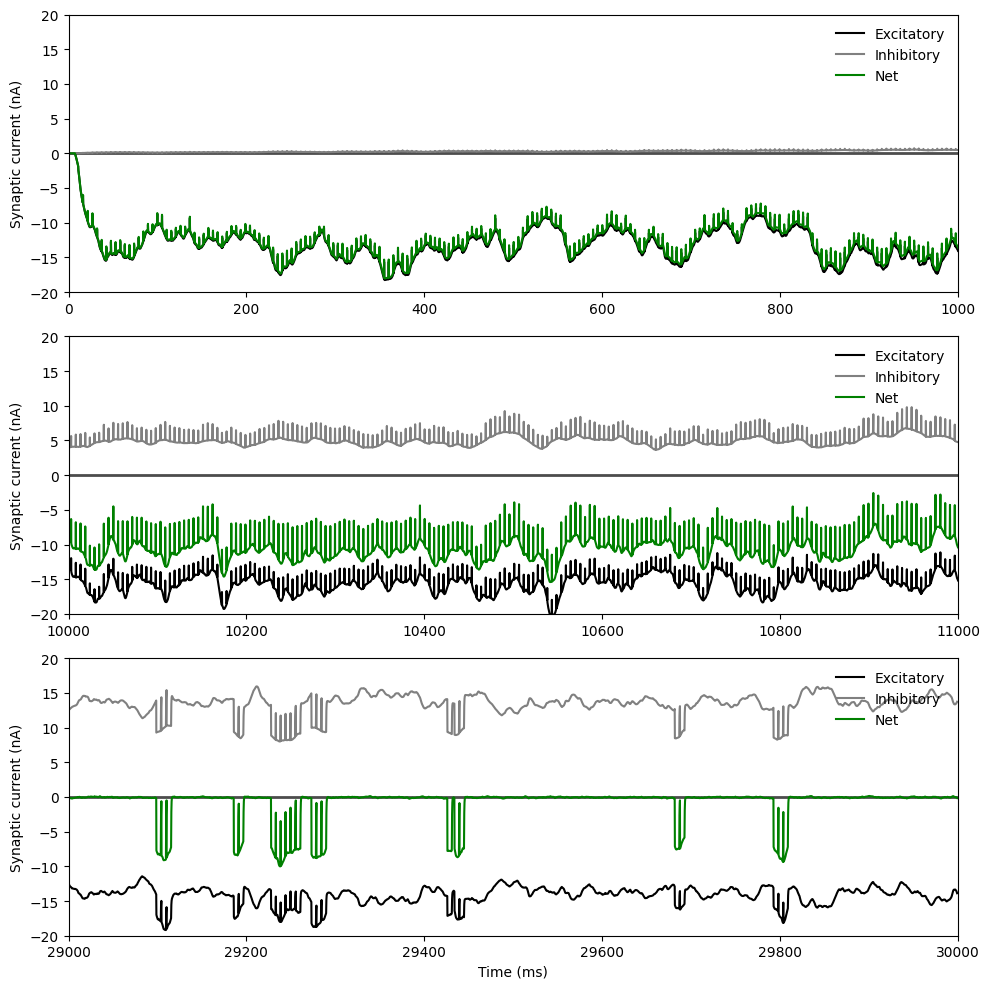

In [14]:
#  Definimos los 3 intervalos de tiempo de o0bservacion
intervalos = [
    (0, 1000),      # Intervalo 1
    (10000, 11000), # Intervalo 2 
    (29000, 30000)  # Intervalo 3
]
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharey=True)

for ax, (inicio, fin) in zip(axs, intervalos):
    ax.axhline(0, color='black', linestyle='-', linewidth=2, alpha=0.7)
    ax.plot(t, I_E/1000, color="black", label="Excitatory")
    ax.plot(t, I_I/1000, color="gray", label="Inhibitory")
    ax.plot(t, I_net/1000, color="green", label="Net")
    
    ax.set_xlim(inicio, fin)
    ax.set_ylim(-20,20)
    ax.set_ylabel("Synaptic current (nA)")
    ax.legend(frameon=False, loc="upper right")
    
 
    #ax.set_title(f"Intervalo: {inicio} - {fin} ms")

axs[-1].set_xlabel("Time (ms)")

plt.tight_layout()
plt.show()


# Fig 1D usando iaf_psc_alpha

In [15]:

import nest
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import time
nest.ResetKernel()
resolution = 0.1
nest.SetKernelStatus({
    "resolution": resolution,   
    "print_time": True
})
np.random.seed(42)

# ==================== PARÁMETROS DEL MODELO ====================
# Neuron model parameters (iaf_cond_alpha como en el artículo)
neuron_params = nest.Create("iaf_psc_alpha", params={
    "C_m": 200.0,
    "tau_m": 20.0,
    "E_L": -60.0,
    "V_th": -50.0,
    "V_reset": -80.0,
    "t_ref": 5.0,
    "tau_syn_ex": 5.0,
    "tau_syn_in": 10.0
})
# Synapse time constants (EXACTAMENTE como en el artículo)
tau_ex = 5.0    # ms (τ_E = 5 ms)
tau_in = 10.0   # ms (τ_I = 10 ms)

# ==================== CREAR NEURONA POSTSINÁPTICA ====================
post = nest.Create("iaf_psc_alpha", params={
    "C_m": 200.0,
    "tau_m": 20.0,
    "V_th": -50.0,
    "V_reset": -60.0,
    "E_L": -60.0,
    "t_ref": 5.0,
    "tau_syn_ex": 5.0,
    "tau_syn_in": 10.0
})


# ==================== CONFIGURACIÓN DE GRUPOS ====================
n_groups = 8                    
N_exc_per_group = 100           
N_inh_per_group = 25           


# ==================== CREAR NEURONAS PARROT POR GRUPO ====================
exc_parrots = []
inh_parrots = []

for g in range(n_groups):
    exc_parrots.append(nest.Create("parrot_neuron", N_exc_per_group))
    inh_parrots.append(nest.Create("parrot_neuron", N_inh_per_group))


# ==================== GENERAR SEÑALES MODULADAS ====================
# Señales de Ornstein-Uhlenbeck con τ = 50 ms (como en el artículo)
T_sim = 10000.0  # ms
dt_signal = 5.0  # ms
tau_signal = 50.0  # ms
times = np.arange(dt_signal, T_sim + dt_signal, dt_signal)
alpha = dt_signal / tau_signal

rate_mean = 10.0  # Hz
rate_std = 5.0    # Hz

signals = []
for g in range(n_groups):
    noise = np.random.randn(len(times))
    signal = np.zeros_like(noise)

    for i in range(1, len(signal)):
        signal[i] = signal[i-1] + alpha * (-signal[i-1] + noise[i])

    signal = (signal - np.mean(signal)) / np.std(signal)
    rates = rate_mean + rate_std * signal
    rates[rates < 0.1] = 0.1
    
    signals.append(rates)

# ==================== SINTONIZACIÓN DE PESOS EXCITATORIOS ====================
# Un grupo preferido (en el artículo es el grupo 5, índice 4)
preferred_group = 4  # Grupo 5 (0-based index 4)
w_exc_max = 300.0   # nS para grupo preferido
w_exc_min = 150.0     # nS para grupos no preferidos


w_exc_by_group = []
for g in range(n_groups):
    if g == preferred_group:
        w_exc_by_group.append(w_exc_max)
    else:
        # Decaimiento exponencial de pesos según distancia al preferido
        distance = abs(g - preferred_group)
        weight = w_exc_min + (w_exc_max - w_exc_min) * np.exp(-distance/2.0)
        w_exc_by_group.append(weight)

# Mostrar pesos
for g, w in enumerate(w_exc_by_group):
    pref = "★" if g == preferred_group else " "
    #print(f"  Grupo {g+1}: {w:.2f} nS {pref}")

# ==================== CREAR GENERADORES DE POISSON ====================
exc_gens = []
inh_gens = []

for g in range(n_groups):
    # Un generador para todas las excitatorias del grupo (misma señal)
    exc_gen = nest.Create("inhomogeneous_poisson_generator", params={
    "rate_times": times.tolist(),
    "rate_values": signals[g].tolist(),
    "origin": 0.0,
    "start": 0.0
     })

    inh_gen = nest.Create("inhomogeneous_poisson_generator", params={
    "rate_times": times.tolist(),
    "rate_values": signals[g].tolist(),
    "origin": 0.0,
    "start": 0.0
    })

    
    exc_gens.append(exc_gen)
    inh_gens.append(inh_gen)

# ==================== PARÁMETROS DE SINAPSIS ====================
delay = 1.0  # ms (mismo para todas)

# Parámetros de plasticidad inhibitoria (Vogels-Sprekeler)
inh_syn_params = {
    "synapse_model": "vogels_sprekeler_synapse",
    "weight":-0.2,      
    "delay": delay,
    "eta": 0.05,        # Tasa de aprendizaje
    "alpha": 0.2,      # Ratio
    "tau": 20.0,        # ms (constante de tiempo STDP)
    "Wmax": -200.0,      # Peso máximo
}

# ==================== CONEXIONES ====================

start_time = time.time()

for g in range(n_groups):
    # 1. Conectar generadores a neuronas parrot (todo a todo dentro del grupo)
    nest.Connect(exc_gens[g], exc_parrots[g], conn_spec="all_to_all")
    nest.Connect(inh_gens[g], inh_parrots[g], conn_spec="all_to_all")
    
    # 2. Excitatorias → neurona postsináptica (peso FIJO, positivo)
    nest.Connect(
        exc_parrots[g], post,
        syn_spec={
            "synapse_model": "static_synapse",
            "weight": w_exc_by_group[g],   # > 0
            "delay": delay
        }
    )

    # 3. Inhibitorias → neurona postsináptica (STDP, peso NEGATIVO)
    nest.Connect(
        inh_parrots[g], post,
        syn_spec=inh_syn_params
    )



inh_conns = nest.GetConnections(
    target=post,
    synapse_model="vogels_sprekeler_synapse"
)



In [16]:
multimeter = nest.Create("multimeter", params={
    "record_from": ["V_m", "I_syn_ex", "I_syn_in"],
    "interval": 0.1
})
nest.Connect(multimeter, post)

nest.Simulate(30000.0)

events = nest.GetStatus(multimeter)[0]["events"]

t = events["times"]
V = events["V_m"]

I_E = events["I_syn_ex"]
I_I = events["I_syn_in"]
I_net = I_E + I_I


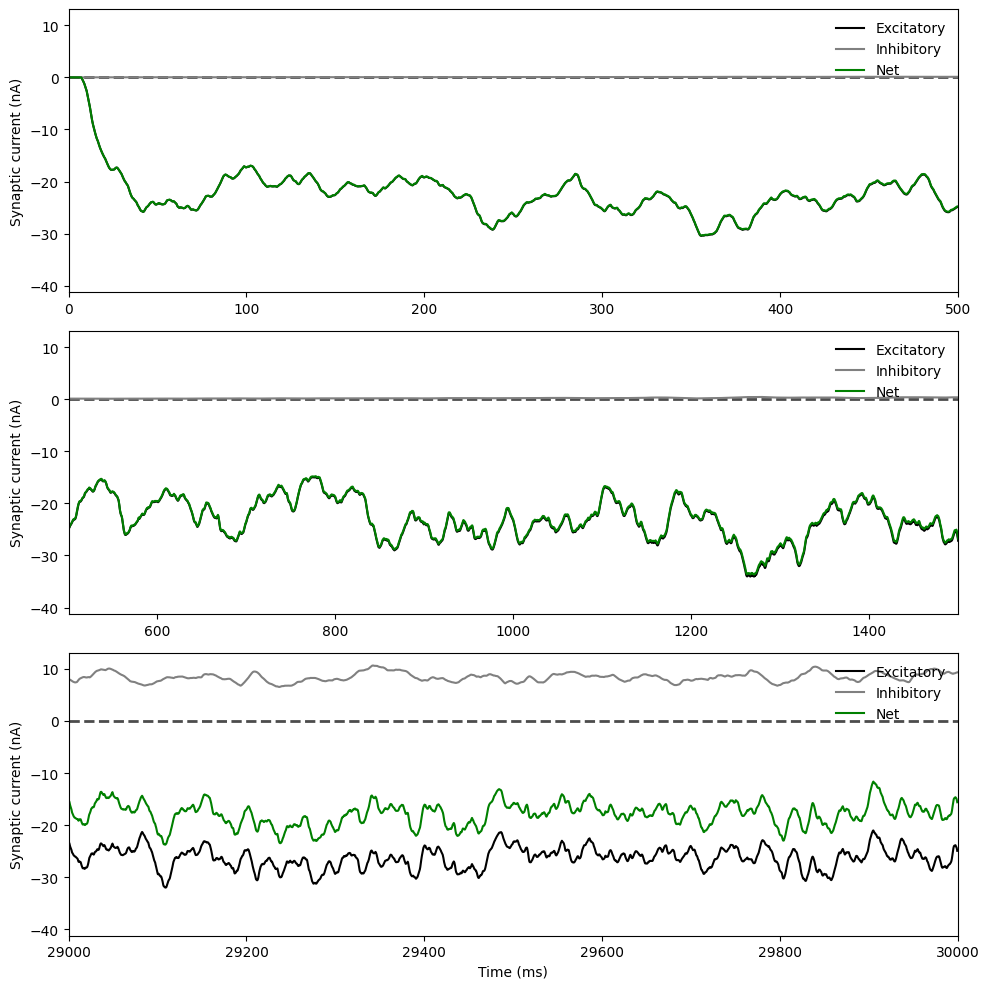

In [21]:
#  Definimos los 3 intervalos de tiempo de o0bservacion
intervalos = [
    (0, 500),      # Intervalo 1
    (500, 1500), # Intervalo 2 
    (29000, 30000)  # Intervalo 3
]
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharey=True)

for ax, (inicio, fin) in zip(axs, intervalos):
    
    ax.axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.7)
    ax.plot(t, -I_E/1000, color="black", label="Excitatory")
    ax.plot(t, -I_I/1000, color="gray", label="Inhibitory")
    ax.plot(t, -I_net/1000, color="green", label="Net")
    
    ax.set_xlim(inicio, fin)
    ax.set_ylabel("Synaptic current (nA)")
    ax.legend(frameon=False, loc="upper right")
    
 
    #ax.set_title(f"Intervalo: {inicio} - {fin} ms")

axs[-1].set_xlabel("Time (ms)")

plt.tight_layout()
plt.show()
